# Racial Bonds

### A statistical analysis of pre-trial detention and bail bond practices in Connecticut

#### by Willie Costello, for the [2020 Ethics4NextGen AI Hackathon](https://dataethics4all.org/ethics4nextgenai-hackathon/)

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Set (optional) display options
plt.rcParams['figure.figsize']=(8.0, 6.0)
%config InlineBackend.figure_format='retina'

In [3]:
sns.set_style("whitegrid")
sns.set_palette('muted')

## Exploring the data

In [83]:
# Read in cleaned dataframe
df = pd.read_csv('data/data_clean.csv')

# Convert date columns to datetime
df['date'] = pd.to_datetime(df['date'])
df['admit_date'] = pd.to_datetime(df['admit_date'])

# Define top three most represented races
wbl = ['White', 'Black', 'Latinx']

# Read in inmate dataframe
inmate_df = pd.read_csv('data/inmate_data.csv')

### Racial demographics of pre-trial inmate population

In [5]:
# Count number of inmates of each race on each day
daily_counts = df.groupby(['date', 'race'])['id'].count()
daily_counts = pd.DataFrame(daily_counts).reset_index()

# Pivot dataframe, for conversion & visualization purposes
counts_df = daily_counts.pivot(index='date', columns='race', values='id')

# Calculate total inmates per day
daily_totals = counts_df.sum(axis=1)

# Divide daily counts by daily totals, to calculate daily percentages
pcts_df = counts_df.divide(daily_totals, axis=0)

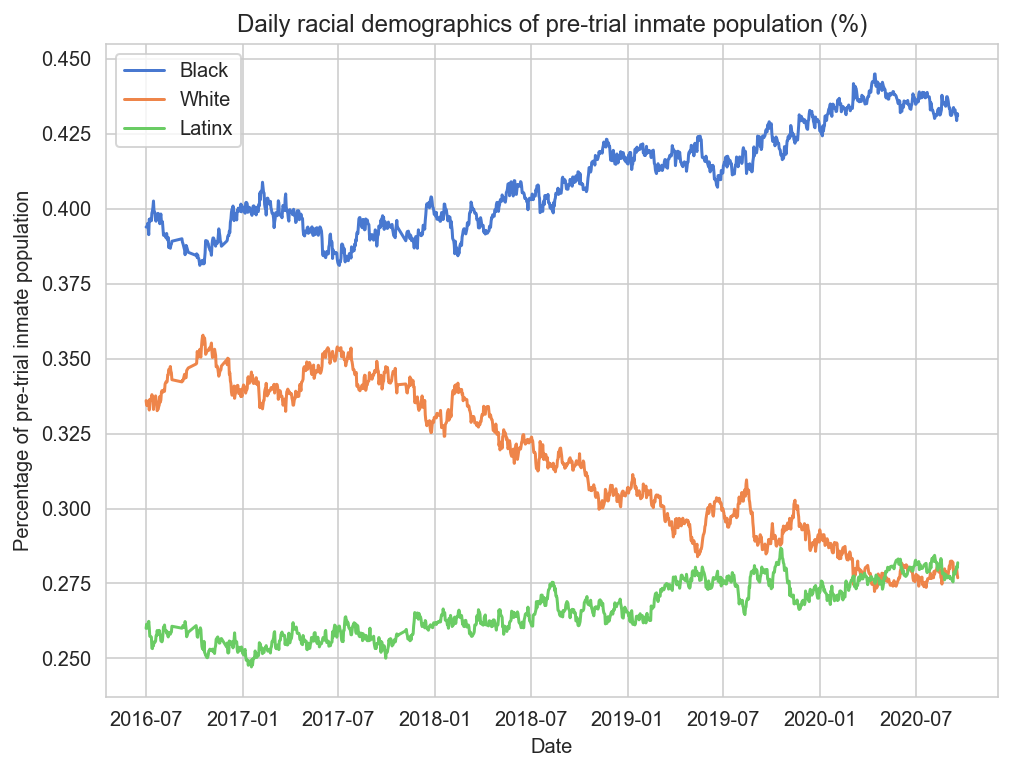

In [6]:
# Plot daily percentages over time
plt.figure()
plt.plot(pcts_df['Black'], label='Black')
plt.plot(pcts_df['White'], label='White')
plt.plot(pcts_df['Latinx'], label='Latinx')
plt.xlabel('Date')
plt.ylabel('Percentage of pre-trial inmate population')
plt.title('Daily racial demographics of pre-trial inmate population (%)')
plt.legend()
plt.savefig('viz/inmate_population_pcts.png', dpi=300)
plt.show()

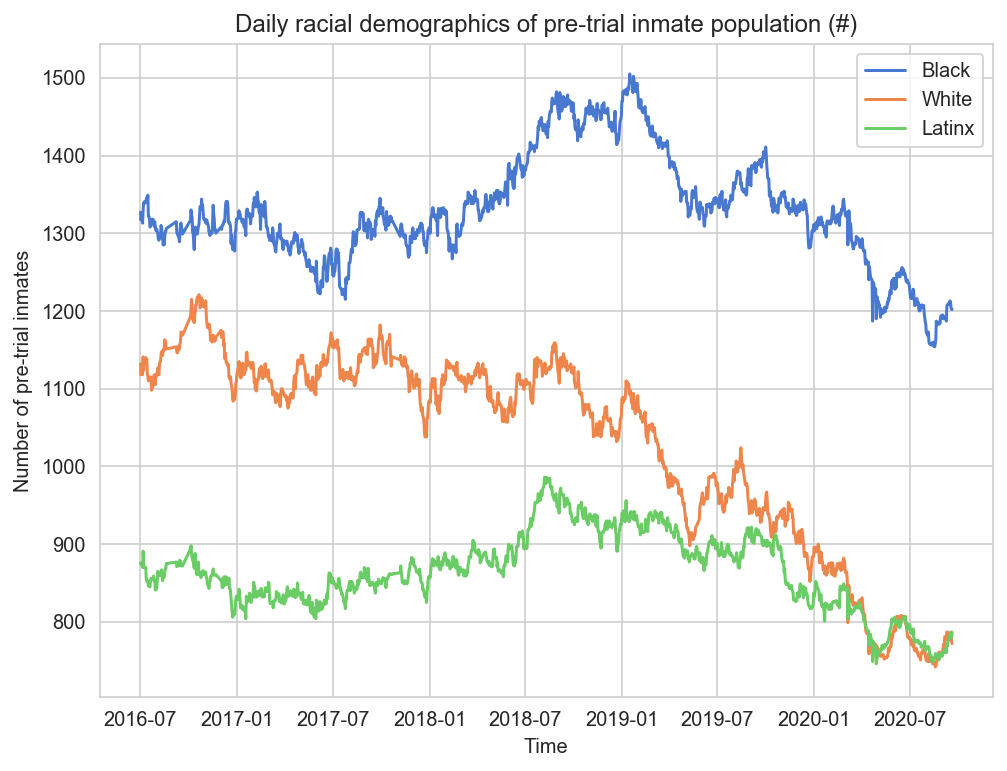

In [7]:
# Plot daily counts over time
plt.figure()
plt.plot(counts_df['Black'], label='Black')
plt.plot(counts_df['White'], label='White')
plt.plot(counts_df['Latinx'], label='Latinx')
plt.xlabel('Time')
plt.xticks()
plt.ylabel('Number of pre-trial inmates')
plt.title('Daily racial demographics of pre-trial inmate population (#)')
plt.legend()
plt.savefig('viz/inmate_population_cts.png', dpi=300)
plt.show()

In [8]:
# Delete df dataframe, to conserve memory
del df

As we can see here, Black people always make up the largest proportion of the pre-trial inmate population. In 2016, White people made up the next largest proportion, but by 2020 White and Latinx people were incarcerated in roughly equal numbers.

### Racial differences in bond amounts & time spent incarcerated

In [9]:
# Set formatting options
pd.options.display.float_format='{:.0f}'.format

In [10]:
# Calculate mean bond amount and number of days spent incarcerated, grouped by race
inmate_df.groupby('ioc')[['days_spent', 'bond']].mean()

,days_spent,bond
ioc,,
0,76,62471
1,102,104212


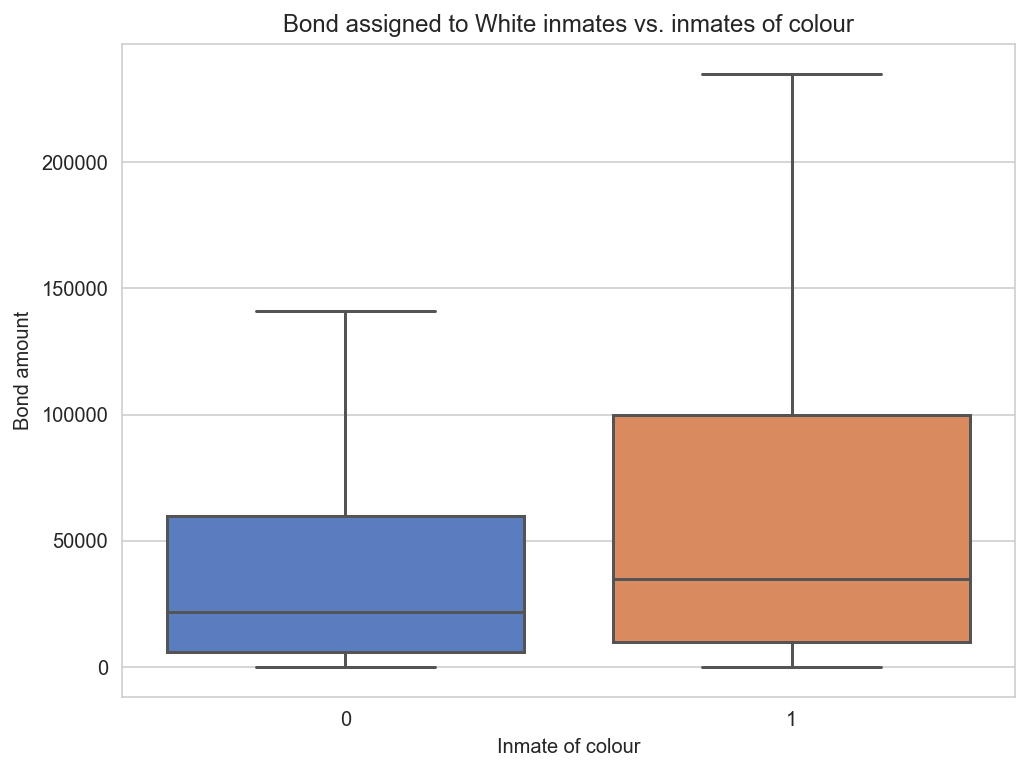

In [11]:
# Visualize it
plt.figure()
sns.boxplot(x='ioc', y='bond', data=inmate_df, showfliers=False)
plt.xlabel('Inmate of colour')
plt.ylabel('Bond amount')
plt.title('Bond assigned to White inmates vs. inmates of colour')
plt.show()

As we can see here, inmates of colour tend to be assigned higher bond amounts and to spend more days in prison than White inmates.

### Controlling for offense type

Is this, however, a result of inmates of colour being arrested for different and more serious types of offenses? Let's investigate this question by looking at a few specific examples.

As can be seen below, the most commonly occurring offense is "Violation of probation or conditional discharge". Let's look at the racial differences for just those inmates arrested for this offense.

In [12]:
# Most commonly occurring offenses
inmate_df['offense'].value_counts().head()

VIOLATION OF PROBATION OR COND DISCHG       10772
CRIM VIOL OF PROTECTIVE ORDER         DF     3872
FAILURE TO APPEAR SECOND DEGREE      AM      3491
INJURY OR RISK OF INJURY TO MINOR      F     2692
ASSAULT THIRD DEGREE                 AM      2163
Name: offense, dtype: int64

In [13]:
# Calculate mean bond and days spent incarcerated for inmates arrested for violation of probation, grouped by race
inmate_df[inmate_df['offense']=='VIOLATION OF PROBATION OR COND DISCHG'].groupby('ioc')[['days_spent', 'bond']].mean()

,days_spent,bond
ioc,,
0,58,48400
1,60,58642


In this case, White inmates tend to spend slightly fewer days in prison than inmates of colour. Despite this, inmates of colour are assigned higher bond amounts.

What if we look at a more serious offense, like assault?

In [14]:
# Create dataframe of all inmates arrested for assault
assault_df = inmate_df[inmate_df['off_abbr']=='ASSAULT']

# Calculate mean bond and days spent incarcerated for inmates arrested for assault, grouped by race
assault_df.groupby('ioc')[['days_spent', 'bond']].mean()

,days_spent,bond
ioc,,
0,86,59111
1,120,102338


What if we control for the degree of the offense?

In [15]:
# Calculate mean bond and days spent incarcerated for inmates arrested for first degree assault
assault_df[assault_df['deg']==1].groupby('ioc')[['days_spent', 'bond']].mean()

,days_spent,bond
ioc,,
0,240,249452
1,277,307840


In [16]:
# Calculate mean bond and days spent incarcerated for inmates arrested for second degree assault
assault_df[assault_df['deg']==2].groupby('ioc')[['days_spent', 'bond']].mean()

,days_spent,bond
ioc,,
0,105,63602
1,103,69988


In [17]:
# Calculate mean bond and days spent incarcerated for inmates arrested for third degree assault
assault_df[assault_df['deg']==3].groupby('ioc')[['days_spent', 'bond']].mean()

,days_spent,bond
ioc,,
0,50,23164
1,56,30941


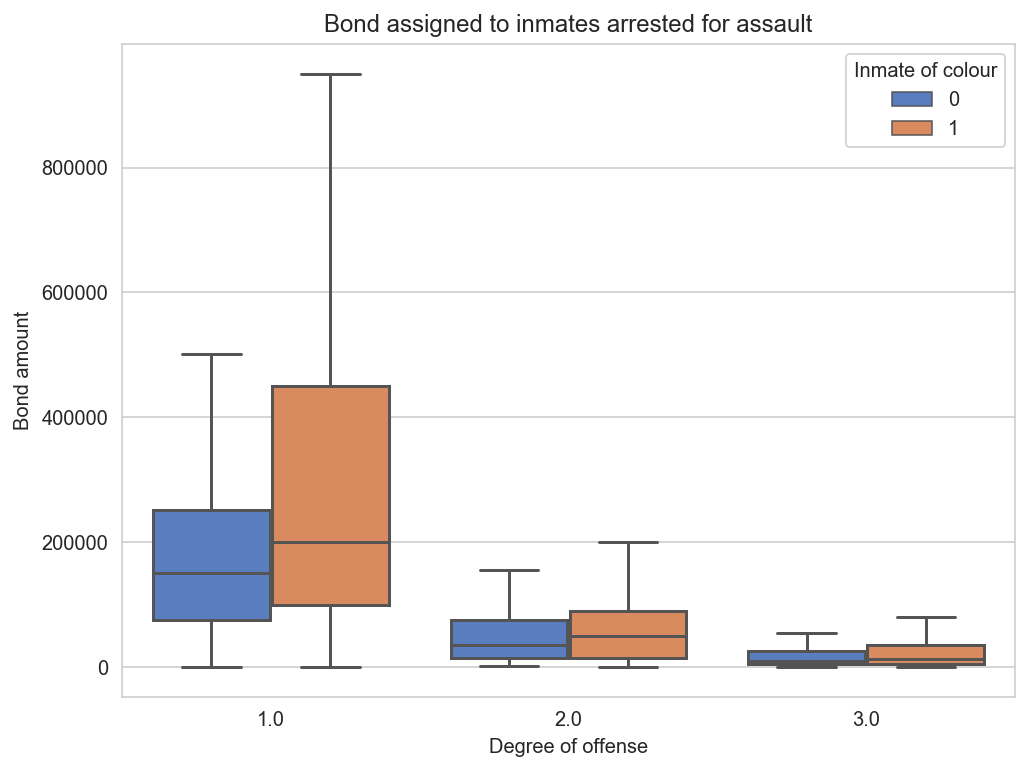

In [18]:
# Visualize it
plt.figure()
sns.boxplot(x='deg', y='bond', hue='ioc', data=assault_df, showfliers=False)
plt.xlabel('Degree of offense')
plt.ylabel('Bond amount')
plt.legend(title='Inmate of colour')
plt.title('Bond assigned to inmates arrested for assault')
plt.show()

Thus, even when the offense is the same, White inmates tend to spend fewer days in prison and be assigned lower bond amounts than inmates of colour.

To be a little more thorough, let's look at the ten most commonly occurring types of offenses and investigate the racial disparities in bond amount.

In [19]:
# Find the ten most commonly occurring types of offenses
inmate_df['off_abbr'].value_counts().head(10)

VIOLATION      10864
ASSAULT         5778
FAILURE         5747
CRIM            5406
LARCENY         3603
CRIMINAL        3330
BURGLARY        2741
INJURY          2693
SALE            2328
INTERFERING     1800
Name: off_abbr, dtype: int64

In [20]:
# Save offense types to a list
top_offenses = inmate_df['off_abbr'].value_counts().head(10).index.tolist()

# Filter data to top offenses
top_offs_df = inmate_df[inmate_df['off_abbr'].isin(top_offenses)]

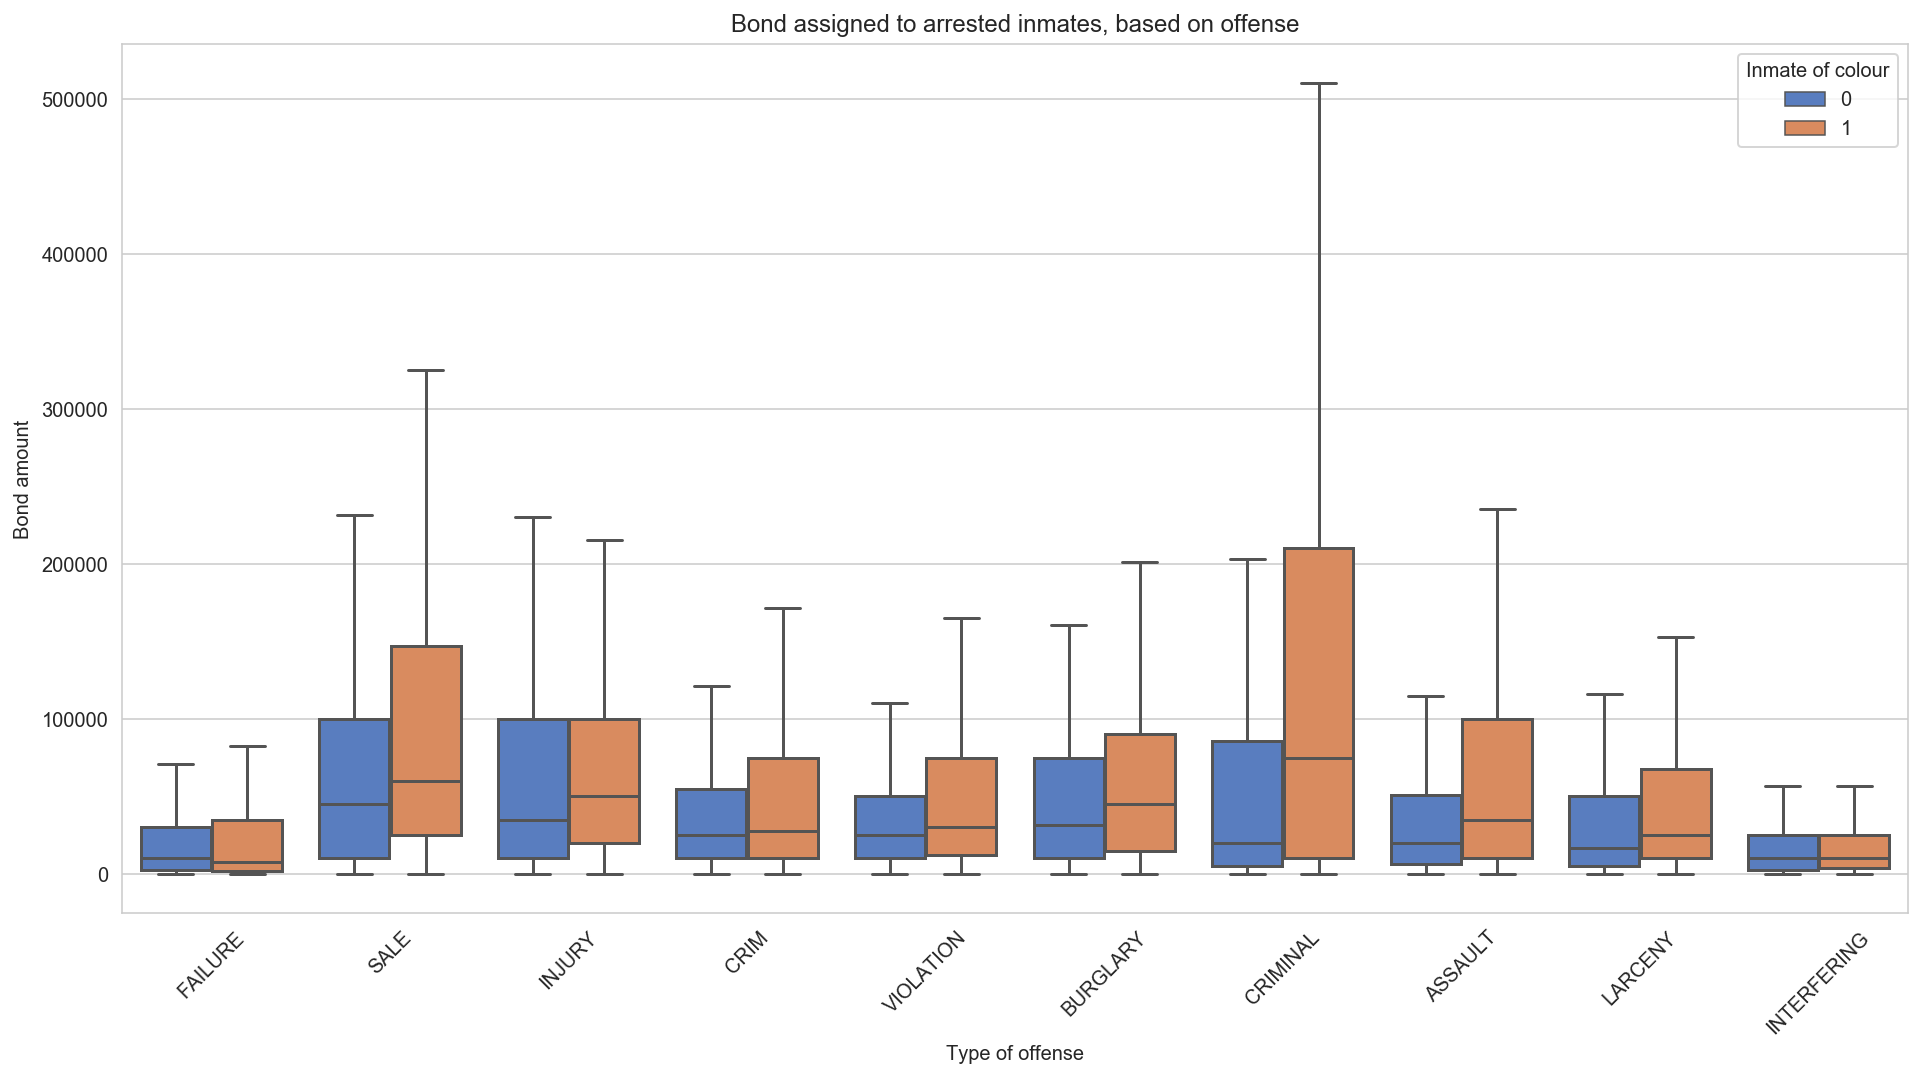

In [21]:
plt.figure(figsize=(16,8))
sns.boxplot(x='off_abbr', y='bond', hue='ioc', data=top_offs_df, showfliers=False)
plt.xlabel('Type of offense')
plt.xticks(rotation=45)
plt.ylabel('Bond amount')
plt.legend(title='Inmate of colour')
plt.title('Bond assigned to arrested inmates, based on offense')
plt.show()

While the pattern is more pronounced in some cases than others, across all these offenses inmates of colour tend to be assigned higher bond amounts than White inmates.

### Controlling for repeat offenders

What else could explain the fact that inmates of colour are assigned higher bond amounts than White inmates? Perhaps it is because inmates of colour are disproportionately repeat offenders, and thus are assigned higher bond amounts than first-time offenders for the same offense?

In [22]:
# Create column indicating whether inmate has been arrested before this offense
inmate_df['repeat'] = inmate_df['id'].duplicated().astype(int)

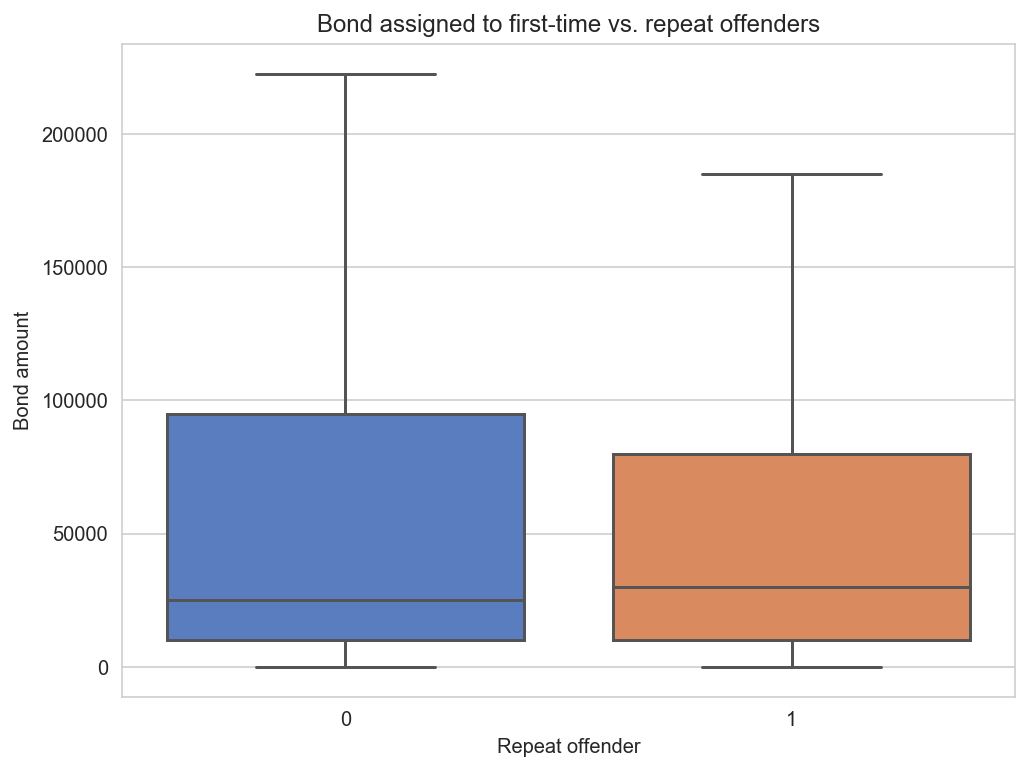

In [23]:
# Visualize it
plt.figure()
sns.boxplot(x='repeat', y='bond', data=inmate_df, showfliers=False)
plt.xlabel('Repeat offender')
plt.ylabel('Bond amount')
plt.title('Bond assigned to first-time vs. repeat offenders')
plt.show()

No striking differences here. The mean bond amount seems slightly higher for repeat offenders than first-timers, but the upper quartile is higher for first-timers.

Perhaps a better question to ask is, Are inmates of colour more likely than White inmates to be repeat offenders?

In [24]:
# Set formatting options
pd.options.display.float_format='{:.3f}'.format

# Count number of first-time & repeat offenders, for each race
repeat_cts = inmate_df.groupby(['ioc', 'repeat'])['id'].count()

# Display relative percentages
repeat_cts.groupby(level=[0]).apply(lambda x: x / x.sum())

ioc  repeat
0    0        0.653
     1        0.347
1    0        0.651
     1        0.349
Name: id, dtype: float64

The answer is no: The relative proportions of first-time and repeat offenders are near identical between White inmates and inmates of colour. As the following plot illustrates, the difference in their bond amounts has nothing to do with whether it is a repeat offense.

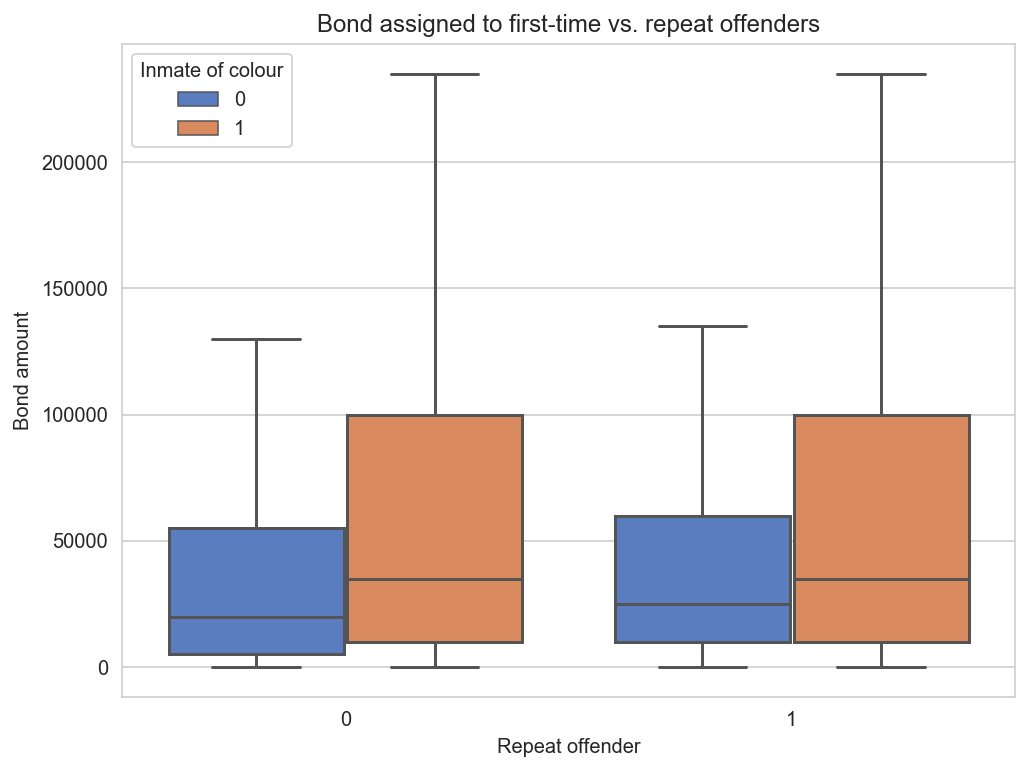

In [25]:
# Visualize it
plt.figure()
sns.boxplot(x='repeat', y='bond', hue='ioc', data=inmate_df, showfliers=False)
plt.xlabel('Repeat offender')
plt.ylabel('Bond amount')
plt.legend(title='Inmate of colour')
plt.title('Bond assigned to first-time vs. repeat offenders')
plt.show()